# In Python 2. Compute the HDDM solution

In [31]:
# automatically apply changes in netgen
%reload_ext autoreload
%autoreload 2

In [32]:
import os, sys
import pandas as pd
import numpy as np
import random
import math
from future.utils import listvalues
from copy import deepcopy

import cbgt.netgen as ng
import cbgt.generateFrames as gf
#import cbgt.analyzefx as afx
#from cbgt import vis, sim

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

%matplotlib inline
clrs = ['#347fff', '#febe08']
eclrs = ['#1657de', '#f5a005']

rc = {'font.family': u'sans-serif',
'font.sans-serif': [u'Helvetica',  u'Arial', u'sans-serif'],
'lines.solid_capstyle': u'butt'}
sns.set(style='ticks', font='Helvetica', rc=rc, font_scale=1.4)
# splot.style(theme='safari-day', grid=True, spines=True, fscale=1.4, figsize=(6., 3.5))
# bdf = pd.read_csv("/Users/kyle/demo_cbgt_bdf.csv")

# Specific for the HDDM study
#import hddm

# Save/load datatables functions

In [3]:
# directory = the filepath to where you want to save your data.  
#   You could use directory="" to save it in the same directory 
#   you are running the notebook in.

# foldername = a name for a new folder to put this specific data set in.
#   The code will create this folder for you.  
#   Whenever you have a new data set, you need to use a new foldername, 
#   otherwise it will overwrite the older results.

def saveData(paramtable,datatables,directory,foldername):
    targetfolder = os.path.join(directory,foldername)
    if not os.path.exists(targetfolder):
        os.makedirs(targetfolder)
    file_name = os.path.join(targetfolder,"param.pkl")
    paramtable.to_pickle(file_name,protocol=0)
    for i in range(len(datatables)):
        file_name = os.path.join(targetfolder,"data"+str(i)+".pkl")
        datatables[i].to_pickle(file_name,protocol=0)
        
def loadData(directory,foldername):
    targetfolder = os.path.join(directory,foldername)
    file_name = os.path.join(targetfolder,"param.pkl")
    paramtable = pd.read_pickle(file_name)
    filecount = len([f for f in os.listdir(targetfolder) 
                     if os.path.isfile(os.path.join(targetfolder, f)) 
                     and f.startswith("data") and f.endswith(".pkl")])
    datatables = []
    for i in range(filecount):
        file_name = os.path.join(targetfolder,"data"+str(i)+".pkl")
        datatables.append(pd.read_pickle(file_name))
    return (paramtable,datatables)

# Global Parameters:

In [4]:
# Working directory
parentDir = 'dftest'
savedir = os.path.join(os.path.expanduser('~'), parentDir)
if not os.path.isdir(savedir):
    os.mkdir(savedir)
saveTest=os.path.join(savedir, 'test')
ng.setDirectory(saveTest)

# HDDM study

In [5]:
import hddm
def fitHDDM(datatables):
    hddm_inputs = []
    hddm_models = []
    hddm_stats = []
    hddm_dbs = []
    for sourcetable in datatables:
        all_obs_data = pd.DataFrame()
        all_obs_data['response'] = 1-sourcetable['decision'] # We flip to have top boundary being Left
        all_obs_data['rt'] = sourcetable['decisiondurationplusdelay']/1000.0
        all_obs_data['reward_code'] = sourcetable['reward']
        all_obs_data.dropna(inplace=True)  # new line
        model = hddm.HDDM(all_obs_data,bias=True)#  include=('z'), depends_on={'v':['reward_code']})
        #model.find_starting_values()
        n_samples = 3000
        n_burn = 500
        n_effective_samples = n_samples - n_burn
        model_db = "basicmodel" + str(len(hddm_stats)) + ".db"
        model.sample(n_samples, burn = n_burn, dbname = model_db, db='pickle')
        stats = model.gen_stats()
        
        hddm_inputs.append(all_obs_data)
        hddm_models.append(model)
        hddm_stats.append(stats)
        hddm_dbs.append(model_db)
    return (hddm_inputs, hddm_models, hddm_stats, hddm_dbs)

In [6]:
## hddm study - create a datatable with the HDDM results of each simulation
import statistics

NumSteps=300
hddm_results=[]
for ns in range(0,NumSteps):
#    if ns not in [11,43,75]:
    foldername="Uniform_Test"+str(ns)
    (paramtable,datatables) = loadData("",foldername)
    
    datatables2=datatables[0].loc[datatables[0]['decision']!=None]
    (hddm_inputs, hddm_models, hddm_stats, hddm_dbs) = fitHDDM([datatables2])
        
    di=dict()
    di['trial']=ns
    di['mean_a']=hddm_stats[0]['mean']['a']
    di['std_a']=hddm_stats[0]['std']['a']
    di['mean_v']=hddm_stats[0]['mean']['v']
    di['std_v']=hddm_stats[0]['std']['v']
    di['mean_t']=hddm_stats[0]['mean']['t']
    di['std_t']=hddm_stats[0]['std']['t']
    di['mean_z']=hddm_stats[0]['mean']['z']
    di['std_z']=hddm_stats[0]['std']['z']
    L=float(sum(hddm_inputs[0]['reward_code']))
    LR=float(len(hddm_inputs[0]['reward_code']))
    di['perc_L']=L/LR*100
    di['perc_R']=(1-L/LR)*100
    di['rt']=statistics.mean(datatables[0].decisionduration) #reaction time
    
    hddm_results.append(di)
        #av.append(hddm_stats[0]['mean']['a'])
        #vv.append(hddm_stats[0]['mean']['v'])
        #tv.append(hddm_stats[0]['mean']['t'])

hddm_datatable=pd.DataFrame(hddm_results)
targetfolder = os.path.join("","hddmSolution")
file_name = os.path.join(targetfolder,"hddmSol.pkl")
if not os.path.exists(targetfolder):
        os.makedirs(targetfolder)
hddm_datatable.to_pickle(file_name)
#file_name = os.path.join(targetfolder,"dataHddm.pkl")
#hddm_inputs.to_pickle(file_name)

 [-----------------100%-----------------] 3000 of 3000 complete in 4.7 sec

# HDDM actual case

In [7]:
## hddm study - create a datatable with the HDDM results of each simulation
import statistics


hddm_results=[]
foldername="ControlCase"
(paramtable,datatables) = loadData("",foldername)
    
datatables2=datatables[0].loc[datatables[0]['decision']!=None]
(hddm_inputs, hddm_models, hddm_stats, hddm_dbs) = fitHDDM([datatables2])
        
di=dict()
di['trial']=1
di['mean_a']=hddm_stats[0]['mean']['a']
di['std_a']=hddm_stats[0]['std']['a']
di['mean_v']=hddm_stats[0]['mean']['v']
di['std_v']=hddm_stats[0]['std']['v']
di['mean_t']=hddm_stats[0]['mean']['t']
di['std_t']=hddm_stats[0]['std']['t']
di['mean_z']=hddm_stats[0]['mean']['z']
di['std_z']=hddm_stats[0]['std']['z']
L=float(sum(hddm_inputs[0]['reward_code']))
LR=float(len(hddm_inputs[0]['reward_code']))
di['perc_L']=L/LR*100
di['perc_R']=(1-L/LR)*100
di['rt']=statistics.mean(datatables[0].decisionduration) #reaction time
    
hddm_results.append(di)

hddm_datatable=pd.DataFrame(hddm_results)
targetfolder = os.path.join("","hddmControlCase")
file_name = os.path.join(targetfolder,"hddmControlCase.pkl")
if not os.path.exists(targetfolder):
        os.makedirs(targetfolder)
hddm_datatable.to_pickle(file_name)


 [-----------------100%-----------------] 3000 of 3000 complete in 4.2 sec

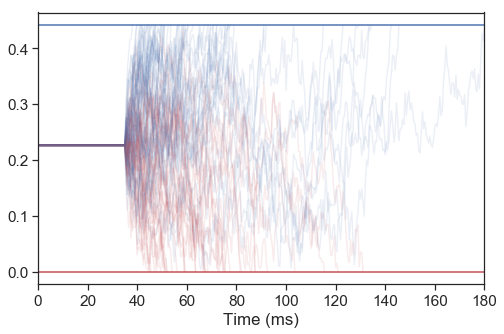

In [160]:
a=hddm_datatable['mean_a'][0]
t=hddm_datatable['mean_t'][0]
v=hddm_datatable['mean_v'][0]
z=hddm_datatable['mean_z'][0]
sigma=0.41
Top=a
Bottom=0
init=z*a

fig = plt.figure(figsize=(8,5))
plt.plot([0,180],[Top,Top],'-b')
plt.plot([0,180],[Bottom,Bottom],'-r')
for i in range(0,100):
    np.random.seed(100*i+1)
    RW=[init]
    dt=0.005
    tau=[0.0]
    while RW[len(RW)-1]>Bottom and RW[len(RW)-1]<Top:
        if tau[len(RW)-1]<=t:
            RW.append(init)
        if tau[len(tau)-1]>t:
            aux=RW[len(RW)-1] + v*dt + sigma*np.random.normal(loc=0.0, scale=np.sqrt(dt))
            if aux<=Bottom:
                RW.append(Bottom)
            elif aux>=Top:
                RW.append(Top)
            else:
                RW.append(aux)
        tau.append((tau[len(tau)-1]+dt))
    if RW[len(RW)-1]==Bottom:
        strc='r'
    else:
        strc='b'
    for i in range(0,len(tau)):
        tau[i]=tau[i]*100
    plt.plot(tau,RW,color=strc, alpha=0.1)


plt.xlim(0,180)
#plt.axis('off')
plt.xlabel('Time (ms)')
plt.show()
figName='DDMexample.png'
fig.savefig(figName, dpi=400)

In [161]:
hddm_datatable

,mean_a,mean_t,mean_v,mean_z,perc_L,perc_R,rt,std_a,std_t,std_v,std_z,trial
0,0.441969,0.345199,0.172864,0.512422,45.333333,54.666667,86.455104,0.012563,0.000363,0.363982,0.023917,1


In [12]:
import hddm
a = hddm_datatable['mean_a'][0]
v = hddm_datatable['mean_v'][0]
t = hddm_datatable['mean_t'][0]
z = hddm_datatable['mean_z'][0]

params = {
    'a': a,
    'st': 0,
    'sv': 0,
    'sz': 0,
    't': t,
    'v': v,
    'z': z,
  }
df = hddm.generate.gen_rts(size=100000, **params)
rtbar=df.rt.mean()

params = {
    'a': a,
    'st': 0,
    'sv': 0,
    'sz': 0,
    't': t,
    'v': v,
    'z': z*1.1,
  }
df = hddm.generate.gen_rts(size=100000, **params)
rtbar_plus=df.rt.mean()

params = {
    'a': a,
    'st': 0,
    'sv': 0,
    'sz': 0,
    't': t,
    'v': v,
    'z': z*0.9,
  }
df = hddm.generate.gen_rts(size=100000, **params)
rtbar_minus=df.rt.mean()

dRT_da=(rtbar_plus-rtbar_minus)/(2*0.1)
print(dRT_da)

-0.000320049997905
